In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
train_data = (pd.read_csv('/content/drive/My Drive/Test/HW3/Reduced_Train_Data.csv', header = None)).to_numpy()
train_labels = (pd.read_csv('/content/drive/My Drive/Test/HW3/trainLabels.csv', header = None)).to_numpy()
test_data = (pd.read_csv('/content/drive/My Drive/Test/HW3/Reduced_Test_Data.csv', header = None)).to_numpy()
test_labels = (pd.read_csv('/content/drive/My Drive/Test/HW3/testLabels.csv', header = None)).to_numpy()

In [4]:
# split data into tarin and validation -> 80%, 20%
dim = train_data.shape
rows_num = 4*dim[0]//5
indx = random.sample(range(dim[0]), rows_num)
validation_data = np.delete(train_data, indx, axis = 0)
validation_labels = np.delete(train_labels, indx, axis = 0)
data = []
labels = []
for i in range(rows_num):
  data.append(train_data[indx[i]])
  labels.append(train_labels[indx[i]])
train_data = np.array(data)
train_labels = np.array(labels)

In [7]:
def InitWeight(n, m):
  weights = np.random.randn(n, m)/np.sqrt(n)
  return weights

In [8]:
def LoadWeight(path):
  weight = np.load(path)
  return weight

In [9]:
def SaveWeight(path, weight):
  np.save(path, weight)

In [46]:
def forward(X, W1, bias1, W2, bias2):
  a1 = np.matmul(np.transpose(W1), X) + bias1
  #f1 = np.tanh(a1)
  f1 = np.maximum(a1, np.zeros((150, 1)))  # ReLU activation function
  a2 = np.matmul(np.transpose(W2), f1) + bias2
  f2 = np.tanh(a2)
  return  f2, f1

In [44]:
# ReLU activation function
def backPropagate(W1, bias1, W2, bias2, eta, y_predicted, y, X, f1):
  d = f1
  for i in range(10):
    if f1[i] > 0:
      d[i] = 1
  help = np.multiply(d, np.matmul(W2, np.multiply((y_predicted - y), (1 - np.power(y_predicted, 2)))))
  W1 -= eta * 0.2 * np.matmul(X, np.transpose(help))
  bias1 -= eta * 0.2 * help
  help = np.multiply((y_predicted - y), (1 - np.power(y_predicted, 2)))
  W2 -= eta * 0.2 * np.matmul(f1, np.transpose(help))
  bias2 -= eta * 0.2 * help
  return W1, bias1, W2, bias2

In [11]:
# tanh activation function
def backPropagate(W1, bias1, W2, bias2, eta, y_predicted, y, X, f1):
  help = np.multiply((1 - np.power(f1, 2)), np.matmul(W2, np.multiply((y_predicted - y), (1 - np.power(y_predicted, 2)))))
  W1 -= eta * 0.2 * np.matmul(X, np.transpose(help))
  bias1 -= eta * 0.2 * help
  help = np.multiply((y_predicted - y), (1 - np.power(y_predicted, 2)))
  W2 -= eta * 0.2 * np.matmul(f1, np.transpose(help))
  bias2 -= eta * 0.2 * help
  return W1, bias1, W2, bias2

In [12]:
def normalizingData(data):
  data -= np.mean(data, axis = 0, keepdims = True)
  data /= np.std(data, axis = 0, keepdims = True)
  return data

In [13]:
def make_One_vs_all(labels):
  dim = labels.shape
  one_vs_all_label = np.zeros((dim[0], 10))
  for i in range(dim[0]):
    one_vs_all_label[i][labels[i]] = 1
  return one_vs_all_label

In [14]:
def Test(W1, W2, bias1, bias2, data, labels):
  count = 0
  loss = 0
  for i in range((data.shape)[0]):
    f2, f1 = forward(np.transpose(np.array([data[i]])), W1, bias1, W2, bias2)
    indx = (np.where(labels[i] == 1))[0]
    if indx == np.argmax(f2):
      count += 1
    loss += np.sum(np.power((f2 - np.transpose([labels[i]])), 2))/10
  count /= (data.shape)[0]
  loss /= (data.shape)[0]
  return count, loss

In [23]:
def Train(eta, train_data, train_labels, validation_labels, validation_data, W1, W2, bias1, bias2, n):
  k = 10
  w1 = np.zeros((k, 128, n))
  b1 = np.zeros((k, n, 1))
  w2 = np.zeros((k, n, 10))
  b2 = np.zeros((k, 10, 1))
  train_accuracy = np.zeros((k, 1))
  train_loss = np.zeros((k, 1))
  validation_accuracy = np.zeros((k, 1))
  validation_loss = np.zeros((k, 1))
  for i in range(k):
    for j in range((train_data.shape)[0]):
      f2, f1 = forward(np.transpose(np.array([train_data[j]])), W1, bias1, W2, bias2)
      W1, bias1, W2, bias2 = backPropagate(W1, bias1, W2, bias2, eta, f2, np.transpose(np.array([train_labels[j]])), np.transpose(np.array([train_data[j]])), f1)
    w1[i] = W1
    b1[i] = bias1
    w2[i] = W2
    b2[i] = bias2
    train_accuracy[i], train_loss[i] = Test(W1, W2, bias1, bias2, train_data, train_labels)
    validation_accuracy[i], validation_loss[i] = Test(W1, W2, bias1, bias2, validation_data, validation_labels)
  SaveWeight('/content/drive/My Drive/Test/HW3/w1', w1)
  SaveWeight('/content/drive/My Drive/Test/HW3/b1', b1)
  SaveWeight('/content/drive/My Drive/Test/HW3/w2', w2)
  SaveWeight('/content/drive/My Drive/Test/HW3/b2', b2)
  return train_accuracy, train_loss, validation_accuracy, validation_loss

In [16]:
# Preprocessing Data
train_data = normalizingData(train_data)
train_labels = make_One_vs_all(train_labels)

validation_data = normalizingData(validation_data)
validation_labels = make_One_vs_all(validation_labels)

test_data = normalizingData(test_data)
test_labels = make_One_vs_all(test_labels)

In [ ]:
# Weight and bias initialization -> Xavier initialization
n = 150   # hidden layer's number of nuerons
W1 = InitWeight(128, n)
W2 = InitWeight(n, 10)
bias1 = np.zeros((n, 1))
bias2 = np.zeros((10, 1))

In [ ]:
train_accuracy, train_loss, validation_accuracy, validation_loss = Train(0.01, train_data, train_labels, validation_labels, validation_data, W1, W2, bias1, bias2, 150) 
print("validation accuracy for eta = 0.01 is:\n", validation_accuracy[29])

validation accuracy for eta = 0.01 is:
 [0.87658333]


In [ ]:
train_accuracy, train_loss, validation_accuracy, validation_loss = Train(0.1, train_data, train_labels, validation_labels, validation_data, W1, W2, bias1, bias2, 150) 
print("validation accuracy for eta = 0.1 is:\n", validation_accuracy[29])

validation accuracy for eta = 0.1 is:
 [0.85633333]


In [ ]:
train_accuracy, train_loss, validation_accuracy, validation_loss = Train(0.001, train_data, train_labels, validation_labels, validation_data, W1, W2, bias1, bias2, 150) 
print("validation accuracy for eta = 0.001 is:\n", validation_accuracy[29])

validation accuracy for eta = 0.001 is:
 [0.86733333]


Training data:

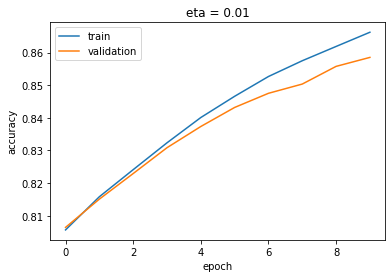

validation accuracy for eta = 0.01 is:
 [0.8585]


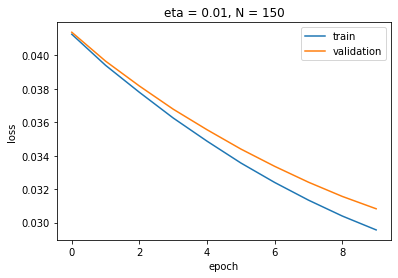

In [24]:
n = 150
W1 = InitWeight(128, n)
W2 = InitWeight(n, 10)
bias1 = np.zeros((n, 1))
bias2 = np.zeros((10, 1))
train_accuracy, train_loss, validation_accuracy, validation_loss = Train(0.01, train_data, train_labels, validation_labels, validation_data, W1, W2, bias1, bias2, n) 

epoch = np.array(list(range(10)))
plt.plot(epoch, train_accuracy, label = "train"") 
plt.plot(epoch, validation_accuracy, label = "validation") 

plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('eta = 0.01')
plt.legend() 
plt.show()
print("validation accuracy for eta = 0.01 is:\n", validation_accuracy[9])

plt.plot(epoch, train_loss, label = "train") 
plt.plot(epoch, validation_loss, label = "validation") 

plt.xlabel('epoch') 
plt.ylabel('loss') 
plt.title('eta = 0.01, N = 150') 
plt.legend() 
plt.show()

In [25]:
W1 = (LoadWeight('/content/drive/My Drive/Test/HW3/w1.npy'))[9]
bias1 = (LoadWeight('/content/drive/My Drive/Test/HW3/b1.npy'))[9]
W2 = (LoadWeight('/content/drive/My Drive/Test/HW3/w2.npy'))[9]
bias2 = (LoadWeight('/content/drive/My Drive/Test/HW3/b2.npy'))[9]
accuracy, loss = Test(W1, W2, bias1, bias2, test_data, test_labels)

print("Test accuracy is:\n", accuracy)
print("Test loss is:\n", loss)

Test accuracy is:
 0.8463
Test loss is:
 0.032027170530471764


Different nodes:

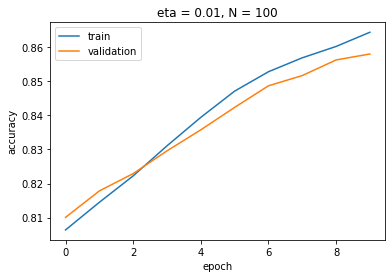

validation accuracy for eta = 0.01 is:
 [0.858]


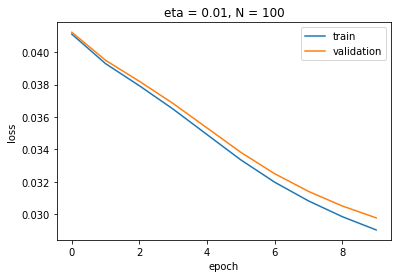

In [26]:
# changing number of hidden layer's nuerons
n = 100
W1 = InitWeight(128, n)
W2 = InitWeight(n, 10)
bias1 = np.zeros((n, 1))
bias2 = np.zeros((10, 1))


train_accuracy, train_loss, validation_accuracy, validation_loss = Train(0.01, train_data, train_labels, validation_labels, validation_data, W1, W2, bias1, bias2, n) 

epoch = np.array(list(range(10)))
plt.plot(epoch, train_accuracy, label = "train") 
plt.plot(epoch, validation_accuracy, label = "validation") 

plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('eta = 0.01, N = 100') 
plt.legend() 
plt.show()
print("validation accuracy for eta = 0.01 is:\n", validation_accuracy[9])


plt.plot(epoch, train_loss, label = "train") 
plt.plot(epoch, validation_loss, label = "validation") 

plt.xlabel('epoch') 
plt.ylabel('loss') 
plt.title('eta = 0.01, N = 100') 
plt.legend() 
plt.show() 

In [27]:
W1 = (LoadWeight('/content/drive/My Drive/Test/HW3/w1.npy'))[9]
bias1 = (LoadWeight('/content/drive/My Drive/Test/HW3/b1.npy'))[9]
W2 = (LoadWeight('/content/drive/My Drive/Test/HW3/w2.npy'))[9]
bias2 = (LoadWeight('/content/drive/My Drive/Test/HW3/b2.npy'))[9]
accuracy, loss = Test(W1, W2, bias1, bias2, test_data, test_labels)

print("Test accuracy is:\n", accuracy)
print("Test loss is:\n", loss)

Test accuracy is:
 0.8468
Test loss is:
 0.03103264046763198


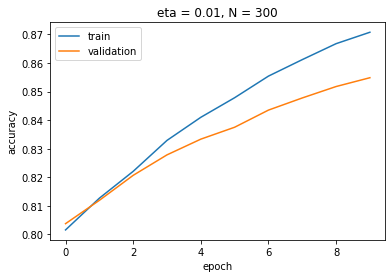

validation accuracy for eta = 0.01 is:
 [0.85483333]


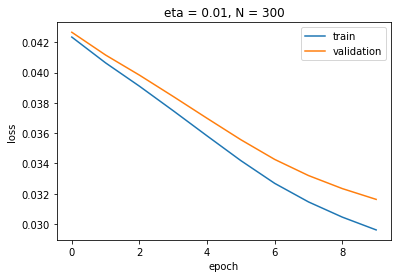

In [28]:
# changing number of hidden layer's nuerons
n = 300
W1 = InitWeight(128, n)
W2 = InitWeight(n, 10)
bias1 = np.zeros((n, 1))
bias2 = np.zeros((10, 1))


train_accuracy, train_loss, validation_accuracy, validation_loss = Train(0.01, train_data, train_labels, validation_labels, validation_data, W1, W2, bias1, bias2, n) 

epoch = np.array(list(range(10)))
plt.plot(epoch, train_accuracy, label = "train") 
plt.plot(epoch, validation_accuracy, label = "validation") 

plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('eta = 0.01, N = 300') 
plt.legend() 
plt.show()
print("validation accuracy for eta = 0.01 is:\n", validation_accuracy[9])


plt.plot(epoch, train_loss, label = "train") 
plt.plot(epoch, validation_loss, label = "validation") 

plt.xlabel('epoch') 
plt.ylabel('loss') 
plt.title('eta = 0.01, N = 300') 
plt.legend() 
plt.show() 

In [29]:
W1 = (LoadWeight('/content/drive/My Drive/Test/HW3/w1.npy'))[9]
bias1 = (LoadWeight('/content/drive/My Drive/Test/HW3/b1.npy'))[9]
W2 = (LoadWeight('/content/drive/My Drive/Test/HW3/w2.npy'))[9]
bias2 = (LoadWeight('/content/drive/My Drive/Test/HW3/b2.npy'))[9]
accuracy, loss = Test(W1, W2, bias1, bias2, test_data, test_labels)

print("Test accuracy is:\n", accuracy)
print("Test loss is:\n", loss)

Test accuracy is:
 0.8453
Test loss is:
 0.03274352742450023


Different activation function:

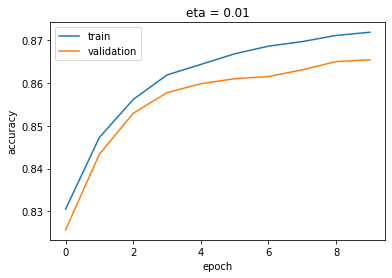

validation accuracy for eta = 0.01 is:
 [0.86541667]


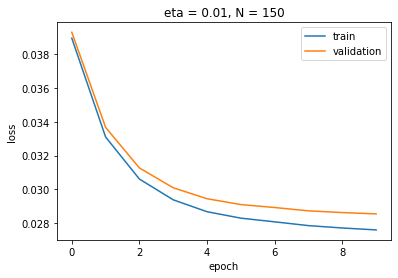

In [47]:
n = 150
W1 = InitWeight(128, n)
W2 = InitWeight(n, 10)
bias1 = np.zeros((n, 1))
bias2 = np.zeros((10, 1))
train_accuracy, train_loss, validation_accuracy, validation_loss = Train(0.01, train_data, train_labels, validation_labels, validation_data, W1, W2, bias1, bias2, n) 

epoch = np.array(list(range(10)))
plt.plot(epoch, train_accuracy, label = "train") 
plt.plot(epoch, validation_accuracy, label = "validation") 

plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('eta = 0.01')
plt.legend() 
plt.show()
print("validation accuracy for eta = 0.01 is:\n", validation_accuracy[9])

plt.plot(epoch, train_loss, label = "train") 
plt.plot(epoch, validation_loss, label = "validation") 

plt.xlabel('epoch') 
plt.ylabel('loss') 
plt.title('eta = 0.01, N = 150') 
plt.legend() 
plt.show()

In [48]:
W1 = (LoadWeight('/content/drive/My Drive/Test/HW3/w1.npy'))[9]
bias1 = (LoadWeight('/content/drive/My Drive/Test/HW3/b1.npy'))[9]
W2 = (LoadWeight('/content/drive/My Drive/Test/HW3/w2.npy'))[9]
bias2 = (LoadWeight('/content/drive/My Drive/Test/HW3/b2.npy'))[9]
accuracy, loss = Test(W1, W2, bias1, bias2, test_data, test_labels)

print("Test accuracy is:\n", accuracy)
print("Test loss is:\n", loss)

Test accuracy is:
 0.8516
Test loss is:
 0.029817871186952328
